# Credit Card Fraud Prediction - Model Training

This demo is based on the Machine Learning for Credit Card Fraud detection - Practical handbook, https://fraud-detection-handbook.github.io/fraud-detection-handbook/

Before running this notebook you need to go through ***01 - Snowpark - Feature Engineering***

Import the libraries we are using

In [1]:
# Snowpark
import snowflake.snowpark as snp
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Session
from snowflake.snowpark.types import PandasDataFrame, PandasSeries
import json

print(f"Using Snowpark: {snp.__version__}")

Using Snowpark: 1.0.0


In [2]:
import datetime
import getpass

import cachetools as ct
import joblib as jl
import numpy as np
import pandas as pd
import sklearn as skl
# Make sure we do not get line breaks when doing show on wide dataframes
from IPython.core.display import HTML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [3]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

Start by connecting to Snowflake and get our data

In [4]:
#Create ses
f = open('/Users/erich.wiehahn/Documents/Training/Snowflake/params.json') #insert creds here
params = json.load(f)

connection_parameters = {
    "user": params['user'],
    "account": params['account'],
    "password": params['password'],
    "database": "credit_fraud",
    "schema": "PUBLIC",
    "role": "ACCOUNTADMIN"
}
session = Session.builder.configs(connection_parameters).create()
#session.sql_simplifier_enabled = True
print(f"Current schema: {session.get_fully_qualified_current_schema()}")
print(f"Current role: {session.get_current_role()}")
print(f"Current warehouse: {session.get_current_warehouse()}")

Current schema: "CREDIT_FRAUD"."PUBLIC"
Current role: "ACCOUNTADMIN"
Current warehouse: "COMPUTE_WH"


Start by making sure we are using a MEDIUM WH since we will pull back data to the client.

In [5]:
def scale_wh(sess, wh, size):
    if (len(wh) == 0): 
        return false
    if (len(size) == 0):
        return false
   
    alter_SQL = "ALTER WAREHOUSE " + wh + " SET WAREHOUSE_SIZE = " + size
    sess.sql(alter_SQL).collect()
    return True

In [6]:
scale_wh(session, session.get_current_warehouse(), "MEDIUM")

True

We will not use the full data set for traing so we need to add a filter. Since we want to be sure that the data we used for training is not changed we will use the zero-copy-cloning feature of Snowflake to create a datasnapshot.

In [7]:
# We will not use the full data set for training/test
start_date_training = datetime.datetime.strptime("2019-05-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7 # Number of days in train, delay and test data sets
end_date_data = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test+1)

# Using Zero-Copy Cloning feature to keep a copy of the data being used for each training

now = datetime.datetime.now()
s = now.strftime("%Y_%m_%d__%H_%M_%S")
print (s);

origin_table_name = "CUSTOMER_TRX_FRAUD_FEATURES"
cloned_table_name = "CUSTOMER_TRX_FRAUD_FEATURES_" + s

sql = "create table " + cloned_table_name + " clone " + origin_table_name

session.sql(sql).collect()
print ("Using Table: ", cloned_table_name)
df_trx = session.table(cloned_table_name).filter((F.col("TX_DATETIME") <= F.to_date(F.lit(end_date_data))) \
                                                 & (F.col("TX_DATETIME") >= F.to_date(F.lit(start_date_training)))).sort(F.col("TX_DATETIME"))
df_trx.show()

2023_08_08__12_57_13
Using Table:  CUSTOMER_TRX_FRAUD_FEATURES_2023_08_08__12_57_13
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"TX_DATETIME"        |"CUSTOMER_ID"  |"TERMINAL_ID"  |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"  |"TX_AMOUNT"  |"TX_FRAUD"  |"TX_FRAUD_SCENARIO"  |"TX_DURING_WEEKEND"  |"TX_DURING_NIGHT"  |"CUST_AVG_AMOUNT_1"  |"CUST_CNT_TX_1"  |"CUST_AVG_AMOUNT_7"  |"CUST_CNT_TX_7"  |"CUST_AVG_AMOUNT_30"  |"CUST_CNT_TX_30"  |"NB_TX_WINDOW_1"  |"TERM_RISK_1"  |"NB_TX_WINDOW_7"  |"TERM_RISK_7"  |"NB_TX_WINDOW_30"  |"TERM_RISK_30"  |
----------------------------------------------------

In [8]:
df_trx.count()

210586

We can get some statistics on our numeric columns by using the **describe**. We are using **to_pandas** to get back the result (5 rows) as a pndas dataframe to use it's printing capabilities

In [9]:
df_trx.describe().show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"TRANSACTION_ID"    |"CUSTOMER_ID"       |"TERMINAL_ID"      |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"     |"TX_AMOUNT"         |"TX_FRAUD"           |"TX_FRAUD_SCENARIO"  |"TX_DURING_WEEKEND"  |"TX_DURING_NIGHT"    |"CUST_AVG_AMOUNT_1"  |"CUST_CNT_TX_1"   |"CUST_AVG_AMOUNT_7"  |"CUST_CNT_TX_7"    |"CUST_AVG_AMOUNT_30"  |"CUST_CNT_TX_30"    |"NB_TX_WINDOW_1"    |"TERM_RISK_1"        |"NB_TX_WINDOW_7"    |"TERM_RISK_7"        |"NB_TX_WINDOW_30"  |"TERM_RISK_30"       |
----------------------------------------

We could also check if any of our columns are highly correlated with each other.
Snowpark does have a correlation function, but not a correlation matrix function, but since we are using Python we can write a function that generates a correlation matrix without puliing back data from Snowflake

In [10]:
def corr_matrix(df):
    # Pick out only those columns that has numeric data type
    numeric_types = [T.DecimalType, T.LongType, T.DoubleType, T.FloatType, T.IntegerType]
    cols = [c.name for c in df.schema.fields if type(c.datatype) in numeric_types]
    cols2 = cols.copy()
    res_df = None
    for col in cols:
        corr_df = (df.agg([F.corr(col, y) for y in cols2])
                   .toDF(cols2)
                   .select(F.lit(col).as_("COLUMN"), *cols2))
        res_df = res_df.union(corr_df) if res_df else corr_df

    return res_df

In [11]:
corr_matrix_df = corr_matrix(df_trx.select(['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUST_CNT_TX_1',
       'CUST_AVG_AMOUNT_1', 'CUST_CNT_TX_7', 'CUST_AVG_AMOUNT_7', 'CUST_CNT_TX_30',
       'CUST_AVG_AMOUNT_30', 'NB_TX_WINDOW_1', 'TERM_RISK_1', 'NB_TX_WINDOW_7','TERM_RISK_7',
        'NB_TX_WINDOW_30','TERM_RISK_30', 'TX_FRAUD'])).toPandas()
corr_matrix_df

,COLUMN,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUST_CNT_TX_1,CUST_AVG_AMOUNT_1,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,NB_TX_WINDOW_1,TERM_RISK_1,NB_TX_WINDOW_7,TERM_RISK_7,NB_TX_WINDOW_30,TERM_RISK_30,TX_FRAUD
0,CUST_AVG_AMOUNT_7,0.721538,-0.001924,-0.003950,0.002698,0.902801,0.000875,1.000000,0.000464,0.959123,0.000990,0.001952,0.000990,0.001952,-0.004632,0.002388,0.065752
1,CUST_CNT_TX_30,0.000103,-0.000579,-0.011464,0.582905,-0.000601,0.883685,0.000464,1.000000,0.004384,0.010117,0.002212,0.010117,0.002212,0.041920,0.000871,-0.001033
2,CUST_CNT_TX_1,0.000264,-0.001673,-0.102883,1.000000,0.000703,0.676873,0.002698,0.582905,0.004174,0.004104,0.002365,0.004104,0.002365,0.023179,-0.000466,-0.001752
3,TX_DURING_NIGHT,-0.001196,0.001310,1.000000,-0.102883,-0.002754,-0.033057,-0.003950,-0.011464,-0.004545,-0.002801,0.000755,-0.002801,0.000755,-0.000094,-0.003141,-0.003123
4,CUST_AVG_AMOUNT_30,0.690446,-0.001763,-0.004545,0.004174,0.863430,0.005116,0.959123,0.004384,1.000000,-0.000717,0.001605,-0.000717,0.001605,-0.005812,0.002397,0.024692
5,NB_TX_WINDOW_30,-0.004276,-0.002346,-0.000094,0.023179,-0.004756,0.034912,-0.004632,0.041920,-0.005812,0.266378,0.011482,0.266378,0.011482,1.000000,0.001936,-0.000863
6,TERM_RISK_30,0.001264,0.001613,-0.003141,-0.000466,0.001477,0.000874,0.002388,0.000871,0.002397,0.003829,0.420066,0.003829,0.420066,0.001936,1.000000,0.232886
7,CUST_CNT_TX_7,-0.000048,0.000191,-0.033057,0.676873,-0.001527,1.000000,0.000875,0.883685,0.005116,0.007062,0.003238,0.007062,0.003238,0.034912,0.000874,-0.001536
8,CUST_AVG_AMOUNT_1,0.801238,-0.000727,-0.002754,0.000703,1.000000,-0.001527,0.902801,-0.000601,0.863430,-0.001295,-0.000190,-0.001295,-0.000190,-0.004756,0.001477,0.097570
9,TERM_RISK_1,-0.001476,-0.002538,0.000755,0.002365,-0.000190,0.003238,0.001952,0.002212,0.001605,0.047974,1.000000,0.047974,1.000000,0.011482,0.420066,0.364459


<AxesSubplot: >

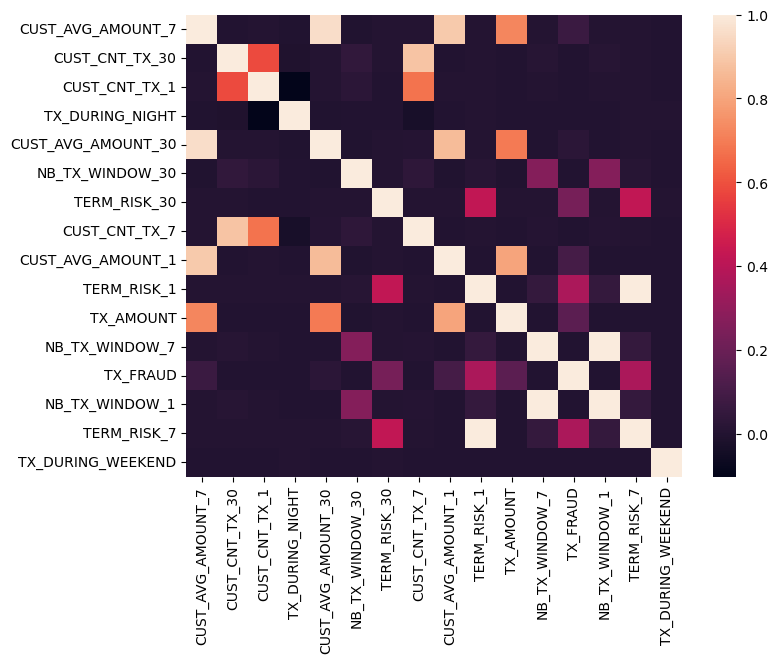

In [12]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(8, 6))


column_order = corr_matrix_df['COLUMN'].to_list()
corr_matrix_df = corr_matrix_df.drop(['COLUMN'], axis=1)[column_order]

sns.heatmap(corr_matrix_df, yticklabels=column_order)

## Split data in training and testing data sets

The training set aims at training a prediction model, while the test set aims at evaluating the performance of the prediction model on new data. In a fraud detection context, the transactions of the test set occur chronologically after the transactions used for training the model.

It is worth noting that we choose our test set to take place one week after the last transaction of the training set. In a fraud detection context, this period separating the training and test set is referred to as the delay period or feedback delay. It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine) is only known after a customer complaint, or thanks to the result of a fraud investigation. Therefore, in a realistic scenario, the annotated data available to train a model and start making prediction for a given day are anterior to that day minus the delay period. Setting a delay period of one week is simplistic. It assumes that the labels (fraudulent or genuine) for all transactions are known exactly one week after they occurred. 

The function below is creating two Snowpark data frames that will return the training and test data sets.

In [13]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):
    
    # Get the training set data
    # Training data is not based on sampling but on a time period
    
    train_df = transactions_df.filter((F.col("TX_DATETIME") >= F.lit(start_date_training)) & (F.col("TX_DATETIME") <= F.lit(start_date_training+datetime.timedelta(days=delta_train))))
    # Get the test set data
    test_dfs = []
    
    # Note: Cards known to be frauded after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known frauded customers from the training set
    known_frauded_customers = train_df.filter(F.col("TX_FRAUD")==F.lit(1)).select(F.col("CUSTOMER_ID"))
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = int(train_df.select(F.min(F.col("TX_TIME_DAYS"))).to_pandas()['MIN("TX_TIME_DAYS")'].values[0])
    # Then, for each day of the test set
    # Get the customers/cards that was not known in the training data and in the delayperiod...
    for day in range(delta_test):
    
        # Get test data for one day, increased by 1 for each loop (starting with 0)
        test_df_day = transactions_df.filter(F.col("TX_TIME_DAYS") == start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day)
        
        # Frauded cards from that test day, minus the delay period, are added to the pool of known frauded customers
        test_df_day_delay_period = transactions_df.filter(F.col("TX_TIME_DAYS") == start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1)
        # fradulent customers identified during the delay period
        new_frauded_customers = test_df_day_delay_period.filter(F.col("TX_FRAUD")==F.lit(1)).select(F.col("CUSTOMER_ID"))
        
        # known_frauded_customers has fradulent customers identified in the training data
        # combine those eith fradulent customers in the delay period, remove duplicates
        known_frauded_customers = known_frauded_customers.union(new_frauded_customers)
        
        # Get the transactions for customers that is not in known_frauded_customers
        test_df_day = test_df_day.join(known_frauded_customers, test_df_day.col("CUSTOMER_ID") == known_frauded_customers.col("CUSTOMER_ID"), 'left')\
                          .filter(F.is_null(known_frauded_customers.col("CUSTOMER_ID")))\
                          .select(F.col("TRANSACTION_ID"), F.col("TX_DATETIME"), test_df_day.col("CUSTOMER_ID").alias("CUSTOMER_ID")\
                                  , F.col("TERMINAL_ID"), F.col("TX_TIME_SECONDS"), F.col("TX_TIME_DAYS"), F.col("TX_AMOUNT"), F.col("TX_FRAUD")\
                                  , F.col("TX_FRAUD_SCENARIO"), F.col("TX_DURING_WEEKEND"), F.col("TX_DURING_NIGHT"), F.col("CUST_AVG_AMOUNT_1")\
                                  , F.col("CUST_CNT_TX_1"), F.col("CUST_AVG_AMOUNT_7"), F.col("CUST_CNT_TX_7"), F.col("CUST_AVG_AMOUNT_30")\
                                  , F.col("CUST_CNT_TX_30"), F.col("NB_TX_WINDOW_1"), F.col("TERM_RISK_1"), F.col("NB_TX_WINDOW_7"), F.col("TERM_RISK_7")\
                                  , F.col("NB_TX_WINDOW_30"), F.col("TERM_RISK_30"))
        # Store as a temporary table?
        # Add it to our test data
        test_dfs.append(test_df_day)
        
    test_df = test_dfs[0].filter(F.is_null(F.col("CUSTOMER_ID")))
    for df in test_dfs:
        test_df = test_df.union(df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort(F.col("TRANSACTION_ID"))
    test_df=test_df.sort(F.col("TRANSACTION_ID"))
    
    return (train_df, test_df)

In [14]:
(df_train, df_test)=get_train_test_set(df_trx,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

How many rows training data set?

In [15]:
df_train.count()

67008

How many fraud rows?

In [16]:
df_train.select(F.sum(F.col("TX_FRAUD"))).show()

-----------------------
|"SUM(""TX_FRAUD"")"  |
-----------------------
|571                  |
-----------------------



Training data fradulent rows (since Fraud is a 0/1 value it is easier to summarize than to count with filter)

The test data set number of rows

In [17]:
df_test.count()

59176

Test data fraudulent rows

In [18]:
df_test.select(F.sum(F.col("TX_FRAUD"))).show()

-----------------------
|"SUM(""TX_FRAUD"")"  |
-----------------------
|374                  |
-----------------------



If we get the mean of the Fraud field we can get the propotion of frauds in our test data set (if we multiply with 100 we get the precentage)

In [19]:
df_test.select(F.avg(F.col("TX_FRAUD"))).show()

-----------------------
|"AVG(""TX_FRAUD"")"  |
-----------------------
|0.006320             |
-----------------------



Have a look at the schema of our training dataframe, we can itirate through the columns (field) to generate a nicer output. 

In [20]:
for col in df_train.schema.fields:
    print(f"{col.name}, Nullable: {col.nullable}, {col.datatype}")

TRANSACTION_ID, Nullable: True, LongType()
TX_DATETIME, Nullable: True, TimestampType()
CUSTOMER_ID, Nullable: True, LongType()
TERMINAL_ID, Nullable: True, LongType()
TX_TIME_SECONDS, Nullable: True, LongType()
TX_TIME_DAYS, Nullable: True, LongType()
TX_AMOUNT, Nullable: True, DoubleType()
TX_FRAUD, Nullable: True, LongType()
TX_FRAUD_SCENARIO, Nullable: True, LongType()
TX_DURING_WEEKEND, Nullable: True, LongType()
TX_DURING_NIGHT, Nullable: True, LongType()
CUST_AVG_AMOUNT_1, Nullable: True, DoubleType()
CUST_CNT_TX_1, Nullable: True, LongType()
CUST_AVG_AMOUNT_7, Nullable: True, DoubleType()
CUST_CNT_TX_7, Nullable: True, LongType()
CUST_AVG_AMOUNT_30, Nullable: True, DoubleType()
CUST_CNT_TX_30, Nullable: True, LongType()
NB_TX_WINDOW_1, Nullable: True, LongType()
TERM_RISK_1, Nullable: True, DecimalType(38, 6)
NB_TX_WINDOW_7, Nullable: True, LongType()
TERM_RISK_7, Nullable: True, DecimalType(38, 6)
NB_TX_WINDOW_30, Nullable: True, LongType()
TERM_RISK_30, Nullable: True, Decima

For this example we will train a model locally

In [21]:
train_df = df_train.to_pandas()
test_df = df_test.to_pandas()

### Train the model

We will define the input and output features as follows:

* The output feature will be the transaction label TX_FRAUD
* The input features will be the transaction amount TX_AMOUNT, as well as all the features that were computed in the previous section, which characterize the context of a transaction.

In [22]:
output_feature="TX_FRAUD"

input_features=["TX_AMOUNT","TX_DURING_WEEKEND", "TX_DURING_NIGHT", "CUST_CNT_TX_1",
       "CUST_AVG_AMOUNT_1", "CUST_CNT_TX_7", "CUST_AVG_AMOUNT_7", "CUST_CNT_TX_30",
       "CUST_AVG_AMOUNT_30", "NB_TX_WINDOW_1", "TERM_RISK_1", "NB_TX_WINDOW_7","TERM_RISK_7",
        "NB_TX_WINDOW_30","TERM_RISK_30"]

In [23]:
# Train a model using the RandomForest classifier

classifier = RandomForestClassifier(random_state=0,n_jobs=-1)
classifier.fit(train_df[input_features], train_df[output_feature])

RandomForestClassifier(n_jobs=-1, random_state=0)

In [24]:
# Get the probablities for fraud for our train and test data sets
predictions_train=classifier.predict_proba(train_df[input_features])[:,1]
predictions_test=classifier.predict_proba(test_df[input_features])[:,1]

In [25]:
# Add the probability to the test data set
test_df['TX_FRAUD_PREDICTED']=predictions_test
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_TIME_SECONDS,TX_TIME_DAYS,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUST_AVG_AMOUNT_1,CUST_CNT_TX_1,CUST_AVG_AMOUNT_7,CUST_CNT_TX_7,CUST_AVG_AMOUNT_30,CUST_CNT_TX_30,NB_TX_WINDOW_1,TERM_RISK_1,NB_TX_WINDOW_7,TERM_RISK_7,NB_TX_WINDOW_30,TERM_RISK_30,TX_FRAUD_PREDICTED
0,652149,2019-06-08 00:00:53,4391,2590,5875253,68,39.03,0,0,1,1,50.140000,7,53.289714,35,60.987679,112,0,0.0,0,0.0,27,0.0,0.0
1,652150,2019-06-08 00:01:11,1582,4549,5875271,68,121.79,0,0,1,1,108.550000,2,65.330000,10,71.112439,41,0,0.0,0,0.0,34,0.0,0.0
2,652151,2019-06-08 00:01:43,2729,2683,5875303,68,92.69,0,0,1,1,92.690000,1,60.568889,18,58.276250,80,0,0.0,0,0.0,28,0.0,0.0
3,652152,2019-06-08 00:04:50,397,8106,5875490,68,80.28,0,0,1,1,63.547778,9,75.442500,20,76.737407,108,3,0.0,3,0.0,49,0.0,0.0
4,652153,2019-06-08 00:05:42,58,1969,5875542,68,17.99,0,0,1,1,9.283333,3,18.573333,9,21.296341,41,1,0.0,1,0.0,31,0.0,0.0


### Assess the performance of the model.

We will compute three performance metrics: The AUC ROC, Average Precision (AP), and Card Precision top-𝑘 (CP@k)

* The Card Precision top-𝑘 is the most pragmatic and interpretable measure. It takes into account the fact that investigators can only check a maximum of 𝑘 potentially fraudulent cards per day. It is computed by ranking, for every day in the test set, the most fraudulent transactions, and selecting the 𝑘 cards whose transactions have the highest fraud probabilities. The precision (proportion of actual frauded cards out of predicted frauded cards) is then computed for each day. The Card Precision top-𝑘 is the average of these daily precisions. The number 𝑘 will be set to 100 (that is, it is assumed that only 100 cards can be checked every day). 

* The Average Precision is a proxy for the Card Precision top-𝑘, that integrates precisions for all possible 𝑘 values.

* The AUC ROC is an alternative measure to the Average Precision, which gives more importance to scores obtained with higher 𝑘 values. It is less relevant in practice since the performances that matter most are those for low 𝑘 values. We however also report it since it is the most widely used performance metric for fraud detection in the literature. 

Note that all three metrics provide values in the interval [0,1], and that higher values mean better performances.

In [26]:
def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_frauded_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_frauded_cards) / top_k
    
    return list_detected_frauded_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_frauded_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected frauded cards is empty
    list_detected_frauded_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_frauded_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected frauded cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_frauded_cards)==False]
        
        nb_frauded_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_frauded_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected frauded cards
        if remove_detected_frauded_cards:
            list_detected_frauded_cards.extend(detected_frauded_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_frauded_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

In [27]:
predictions_df=test_df
predictions_df['predictions']= predictions_test 
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.867,0.631,0.3


The most interpretable metric is the Card Precision@100, which tells us that every day, 30% of the cards with the highest fraudulent scores were indeed compromised. Since the percentage of frauds in the test set is 0.6%, this proportion of detected frauds is high, and means that the classifier indeed manages to do much better than chance.

The interpretation of the AUC ROC and Average Precision is less straightforward. However, by definition, it is known that a random classifier would give an AUC ROC of 0.5, and an Average Precision of 0.006 (the proportion of frauds in the test set). The obtained values are much higher (0.866) and (0.65), confirming the ability of the classifier to provide much better predictions than a random model.

In [28]:
predictions_df['predictions']=0.5
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.5,0.006,0.016


### Deploy model to Snowflake

In order to use the model in Snowflake for scoring data we need to create a Python UDF.

There is two ways on how we can deploy the model object, classifier, to Snowflake. 
1. We can use the variable directly and have the model object included in UDF code
2. We can save it to a file and upload it to a stage and load it form the stage when the UDF is called


In this example we will use the second option.

First we save the model object to a file.

In [29]:
jl.dump(classifier, 'predict_fraud.joblib')

['predict_fraud.joblib']

Since we are creating a permanent function we need to use a stage so Snowpark can upload our code and model

In [30]:
session.sql("CREATE STAGE IF NOT EXISTS UDFSTAGE").collect()

[Row(status='Stage area UDFSTAGE successfully created.')]

Upload the model file to the new stage

In [31]:
session.file.put("predict_fraud.joblib", "@UDFSTAGE", auto_compress=False, overwrite=True)

[PutResult(source='predict_fraud.joblib', target='predict_fraud.joblib', source_size=7459498, target_size=7459504, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

Below code creates a Python UDF in Snowflake that uses our model (that we trained earlier) for scroing of data.

We need to provide the packages we will use in the function by **add_packages** and since we are seperatinmg our model from the function we also need to make 
the UDF aware of the filw by using **add_import**

We need to check that what versions we are using localy and also what versions that are avalible in Snowflake, so our IDF is using the same versions.

In [32]:
print(f"Local Pandas version: {pd.__version__}")
print(f"Local scikit-learn version: {skl.__version__}")
print(f"Local joblib version: {jl.__version__}")
print(f"Local cachetools version: {ct.__version__}")

Local Pandas version: 1.4.4
Local scikit-learn version: 1.1.3
Local joblib version: 1.1.1
Local cachetools version: 4.2.2


Get the versions of pandas, scikit-learn, joblib and cachetools that are avalible in Snowflake. 
**If you are using newer or older versions than what is avalible in Snowflake the UDF might not work, you can install the same versions by using the Snowflake CONDA channel
, https://repo.anaconda.com/pkgs/snowflake**

In [33]:
session.table("information_schema.packages").filter((F.col("language") == 'python') \
                                                    & F.col("PACKAGE_NAME").in_(['pandas', 'scikit-learn', 'joblib', 'cachetools']))\
        .sort(F.col("PACKAGE_NAME").asc(), F.col("VERSION").desc()).show(50)

---------------------------------------------------------------
|"PACKAGE_NAME"  |"VERSION"  |"LANGUAGE"  |"RUNTIME_VERSION"  |
---------------------------------------------------------------
|cachetools      |4.2.2      |python      |3.9                |
|cachetools      |4.2.2      |python      |3.8                |
|cachetools      |4.2.2      |python      |3.10               |
|cachetools      |4.2.1      |python      |3.8                |
|cachetools      |4.2.1      |python      |3.10               |
|cachetools      |4.2.1      |python      |3.9                |
|cachetools      |4.2.0      |python      |3.9                |
|cachetools      |4.2.0      |python      |3.10               |
|cachetools      |4.2.0      |python      |3.8                |
|cachetools      |4.1.1      |python      |3.10               |
|cachetools      |4.1.1      |python      |3.8                |
|cachetools      |4.1.1      |python      |3.9                |
|cachetools      |4.1.0      |python    

We then set the versions we want the UDF to use, same as local, as part of the **add_packages** parameter

In [34]:
session.clear_imports()
session.clear_packages()
session.add_import("@UDFSTAGE/predict_fraud.joblib")
session.add_packages("joblib==1.1.1", "scikit-learn==1.1.3", "cachetools==4.2.2", "pandas==1.4.4")

We will create two functions to be used for scoring.

**read_file** is a helper function that is used with **cachetools** to make sure we only load the model file once and **detect_fraud_batch** is the function that does the scoring. We are using the Python UDF Batch API to create a vectorized UDF that takes a Pandas Dataframe as input, meaning we get fewer calls since each call is on a number of rows at the time (as opposite to a Scalar UDF where we get one row for each call).

In [35]:
@ct.cached(cache={})
def read_file(filename):
    import os
    import sys

    import joblib
    
    import_dir = sys._xoptions.get("snowflake_import_directory")
    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

@F.udf(name = 'detect_fraud_batch_udf', is_permanent = True, replace = True, stage_location = '@UDFSTAGE')
def detect_fraud_batch(ds: PandasSeries[dict]) -> PandasSeries[float]:
    # The dict in the input series will have all columns in the dataframe/table, so
    # we will make sure we only keep those that is used for input to our model
    df = pd.io.json.json_normalize(ds)[input_features]
    pipeline = read_file('predict_fraud.joblib')
    return pipeline.predict_proba(df)[:,1]

The **Session.udf.describe** function will give us information about our new UDF in Snowflake

In [36]:
session.udf.describe(detect_fraud_batch).show()

------------------------------------------------------------------------
|"property"       |"value"                                             |
------------------------------------------------------------------------
|signature        |(ARG1 OBJECT)                                       |
|returns          |FLOAT                                               |
|language         |PYTHON                                              |
|null handling    |CALLED ON NULL INPUT                                |
|volatility       |VOLATILE                                            |
|body             |NULL                                                |
|imports          |[@CREDIT_FRAUD.PUBLIC.UDFSTAGE/predict_fraud.jo...  |
|handler          |udf_py_647365031.compute                            |
|runtime_version  |3.8                                                 |
|packages         |['joblib==1.1.1','scikit-learn==1.1.3','cacheto...  |
---------------------------------------------------

We have now deployed the function and the model to Snowflake and can use it.

In [37]:
df_cust_trx = session.table("CUSTOMER_TRX_FRAUD_FEATURES").filter(F.col("TX_DATETIME") > "2019-07-15 00:00:00")
df_cust_trx.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"TX_DATETIME"        |"CUSTOMER_ID"  |"TERMINAL_ID"  |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"  |"TX_AMOUNT"  |"TX_FRAUD"  |"TX_FRAUD_SCENARIO"  |"TX_DURING_WEEKEND"  |"TX_DURING_NIGHT"  |"CUST_AVG_AMOUNT_1"  |"CUST_CNT_TX_1"  |"CUST_AVG_AMOUNT_7"  |"CUST_CNT_TX_7"  |"CUST_AVG_AMOUNT_30"  |"CUST_CNT_TX_30"  |"NB_TX_WINDOW_1"  |"TERM_RISK_1"  |"NB_TX_WINDOW_7"  |"TERM_RISK_7"  |"NB_TX_WINDOW_30"  |"TERM_RISK_30"  |
----------------------------------------------------------------------------------------------------------------------------------------

We can use the function name, **detect_fraud_batch**, when using the Snowpark API to call the UDF. **object_construct** is used to create the input dict.

In [38]:
df_cust_trx.select(F.col("TRANSACTION_ID"), F.col("TX_DATETIME"), F.col("CUSTOMER_ID"), F.col("TERMINAL_ID"), 
                   detect_fraud_batch(F.object_construct('*')).as_("FRAUD_PROB")).sort("FRAUD_PROB", ascending=False).show()

-----------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"TX_DATETIME"        |"CUSTOMER_ID"  |"TERMINAL_ID"  |"FRAUD_PROB"  |
-----------------------------------------------------------------------------------------
|1133961           |2019-07-28 08:53:06  |919            |3224           |0.99          |
|1157371           |2019-07-30 15:16:12  |871            |4495           |0.99          |
|1008929           |2019-07-15 07:31:38  |250            |8418           |0.98          |
|1094805           |2019-07-24 07:17:02  |960            |7398           |0.97          |
|1116800           |2019-07-26 11:52:56  |4884           |9323           |0.97          |
|1018064           |2019-07-16 06:42:38  |1817           |7427           |0.97          |
|1193091           |2019-08-03 11:09:43  |4557           |9904           |0.97          |
|1062363           |2019-07-20 16:17:08  |2157           |7275           |0.97          |
|1009485  

If we want to do the same with SQL we could run the following where we need to use the name of the UDF, **detect_fraud_batch_udf**

`SELECT TRANSACTION_ID, TX_DATETIME, CUSTOMER_ID, TERMINAL_ID, TX_AMOUNT, detect_fraud_batch_udf(OBJECT_CONSTRUCT(*)) AS FRAUD_PROB 
FROM CUSTOMER_TRX_FRAUD_FEATURES 
WHERE TX_DATETIME > '2019-07-15 00:00:00' LIMIT 10;`